## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
train = pd.read_csv('./data/train.csv')
train.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


### Checking Null Values

In [3]:
train.isnull().sum().sum()

21322

Comment: Large number of null values in the `Name` and `OutcomeSubtype` column. Will look into this further

### Data Clean-Up

Dropping OutcomeSubtype since it's closely related to our target column as well as it not showing in the `test.csv` excel spreadsheet

In [4]:
train.drop(['OutcomeSubtype'], axis = 1, inplace = True)

#### Binarizing Name Column

In [5]:
train['Name'] = train['Name'].fillna(0)

In [6]:
train['Name'] = [1 if i not in train['Name'] else 0 for i in train['Name']]

#### Transforming DateTime Column

In [7]:
train['DateTime'] = pd.to_datetime(train['DateTime'])
train['DateTime']

0       2014-02-12 18:22:00
1       2013-10-13 12:44:00
2       2015-01-31 12:28:00
3       2014-07-11 19:09:00
4       2013-11-15 12:52:00
                ...        
26724   2015-05-14 11:56:00
26725   2016-01-20 18:59:00
26726   2015-03-09 13:33:00
26727   2014-04-27 12:22:00
26728   2015-07-02 09:00:00
Name: DateTime, Length: 26729, dtype: datetime64[ns]

Will create columns out of the months to assess whether or not adoptions occur in a particular month more than others

In [8]:
train['month'] = train['DateTime'].apply(lambda dt: dt.month)
train['month'][0:5]

0     2
1    10
2     1
3     7
4    11
Name: month, dtype: int64

In [9]:
def to_month(num):
    num = int(num)
    if num == 1:
        return 'Jan'
    elif num == 2:
        return 'Feb'
    elif num == 3:
        return 'Mar'
    elif num == 4:
        return 'Apr'
    elif num == 5:
        return 'May'
    elif num == 6:
        return 'Jun'
    elif num == 7:
        return 'Jul'
    elif num == 8:
        return 'Aug'
    elif num == 9:
        return 'Sept'
    elif num == 10:
        return 'Oct'
    elif num == 11:
        return 'Nov'
    else:
        return 'Dec'

train['month'] = train['month'].map(to_month)
train['month']

0        Feb
1        Oct
2        Jan
3        Jul
4        Nov
        ... 
26724    May
26725    Jan
26726    Mar
26727    Apr
26728    Jul
Name: month, Length: 26729, dtype: object

In [10]:
dummies_month = pd.get_dummies(train['month'])

### Dummy Variables - AnimalType

In [11]:
animal_type = pd.get_dummies(train['AnimalType'])

### Dummy Variables - SexuponOutcome

In [12]:
sex_type = pd.get_dummies(train['SexuponOutcome'])

### Checking Columns `SexuponOutcome` and `AgeuponOutcome`

Since there's only one null value for `SexuponOutcome`, I am confident enought that the outcome of myresults won't be affected by dropping that row. with `AgeuponOutcome`, I will go ahead and add the `mean` age value into the missing rows

In [13]:
train.dropna(subset = ['SexuponOutcome'], inplace = True)

In [14]:
#function to convert age to years
#credit to https://www.kaggle.com/slegra78/animals-in-shelters

def calc_age_in_years(x):
    x = str(x)
    if x == 'nan': return 
    age = int(x.split()[0])
    if x.find('year') > -1: return age #'year' is found anywhere on the string
    if x.find('month')> -1: return age / 12. 
    if x.find('week')> -1: return age / 52.
    if x.find('day')> -1: return age / 365.
    else: return 0

In [15]:
train['AgeuponOutcome'] = train['AgeuponOutcome'].map(calc_age_in_years)
train['AgeuponOutcome']

0        1.000000
1        1.000000
2        2.000000
3        0.057692
4        2.000000
           ...   
26724    0.083333
26725    0.250000
26726    4.000000
26727    0.076923
26728    1.000000
Name: AgeuponOutcome, Length: 26728, dtype: float64

will fill in the mean for empty values with `mean`

In [16]:
train['AgeuponOutcome'] = train['AgeuponOutcome'].fillna(train['AgeuponOutcome'].mean())

### Dummy Variables - Breed

Due to multiple breeds listed in this column, will sort out purebreds and mixed breeds

In [17]:
train['Breed'].head(15)

0                 Shetland Sheepdog Mix
1                Domestic Shorthair Mix
2                          Pit Bull Mix
3                Domestic Shorthair Mix
4           Lhasa Apso/Miniature Poodle
5     Cairn Terrier/Chihuahua Shorthair
6                Domestic Shorthair Mix
7                Domestic Shorthair Mix
8         American Pit Bull Terrier Mix
9                         Cairn Terrier
10               Domestic Shorthair Mix
11              Miniature Schnauzer Mix
12                         Pit Bull Mix
13                Yorkshire Terrier Mix
14                   Great Pyrenees Mix
Name: Breed, dtype: object

In [16]:
sorted_breeds = []
for i in train['Breed']:
    if 'Mix' in i:
        sorted_breeds.append('mixed')
    elif '/' in i:                       #assuming that rows with "/" are mixed
        sorted_breeds.append('mixed')        
    else:
        sorted_breeds.append('pure')
sorted_breeds[0:4]

['mixed', 'mixed', 'mixed', 'mixed']

In [17]:
train['pure_or_mix'] = sorted_breeds

In [18]:
pure_or_mix = pd.get_dummies(train['pure_or_mix'])

### Colors Column

Too many colors to dummify, I would drop this column and take a look at this column depending on how the model performs

In [19]:
train.drop(columns = ['Color'], inplace = True)

### Creating Dummy Values for Categorical Columns

In [20]:
train['y'] = train['OutcomeType'].map({'Adoption': 0,
                                      'Died': 1,
                                      'Euthanasia': 2,
                                      'Return_to_owner': 3,
                                      'Transfer': 4})

In [21]:
train = pd.concat([train, animal_type, sex_type, pure_or_mix, dummies_month], axis = 1)

Dropping rows where null value exists (null values at this stage of the data cleaning were less than 20)

In [22]:
train.dropna(inplace=True)

### EDA

#### Delving into some stats between dogs and cats

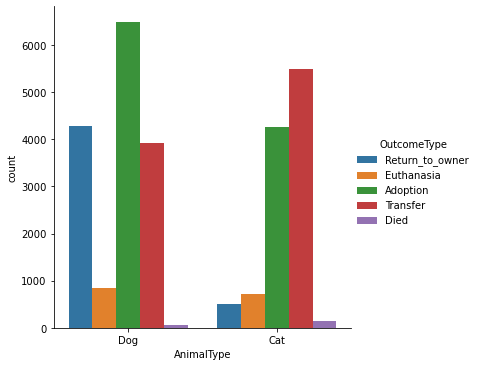

In [23]:
sns.catplot(x="AnimalType", hue="OutcomeType", data=train, kind="count");

Two things stood out for me here: Most dogs appear to be adopted more than cats, and most cats were transferred out of the shelter

Majority of animals do not go adopted in the shelter

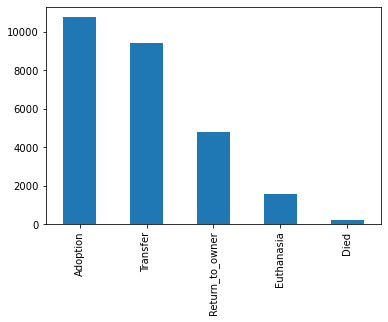

In [24]:
train['OutcomeType'].value_counts().plot(kind = 'bar');

### Establishing Variables for Modeling

In [26]:
X= train.drop(['AnimalID', 'OutcomeType', 'DateTime', 'AnimalType', 'SexuponOutcome', 'Breed', 'month', 'pure_or_mix', 'y'], axis = 'columns')
y= train['y']
print(X.shape)
print(y.shape)

(26710, 23)
(26710,)


In [27]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 42, test_size = 0.15, stratify = y)

### Establishing Baseline Accuracy

In [28]:
y.value_counts(normalize = True)

0.0    0.403182
4.0    0.352153
3.0    0.179146
2.0    0.058143
1.0    0.007376
Name: y, dtype: float64

#### Model 1: Random Forest

In [29]:
rf = RandomForestClassifier(random_state=42, class_weight="balanced")         

In [30]:
cross_val_score(rf, X_train, y_train, cv = 5).mean()

0.5423955308801746

In [31]:
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [32]:
rf_params = {
    'n_estimators': [50, 100, 150],      
    'max_depth': [3, 4, 5],
    'min_samples_split': [3, 5, 7],
    'min_samples_leaf': [2, 3],
    'max_features': ['auto', 'log2']      
}

In [33]:
gs_rf = GridSearchCV(rf, param_grid=rf_params, cv=5, n_jobs = -2, verbose = True)
gs_rf.fit(X_train, y_train)
print(gs_rf.best_score_)
gs_rf.best_params_

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-2)]: Done 194 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-2)]: Done 444 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-2)]: Done 540 out of 540 | elapsed:  2.1min finished


0.4666343845162092


{'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 7,
 'n_estimators': 150}

In [34]:
gs_rf.score(X_train, y_train), gs_rf.score(X_val, y_val)

(0.46046777958860063, 0.4646867981033192)

#### Model 2: Single Decision Tree

In [35]:
dt = DecisionTreeClassifier(random_state = 42)

In [36]:
cross_val_score(dt, X_train, y_train, cv = 5).mean()

0.6057792195823272

In [37]:
dt_params = {
    'max_depth': [3, 4, 5],          
    'min_samples_split': [3, 5, 7],  
    'min_samples_leaf': [3, 4]       
}
gs_dt = GridSearchCV(dt, param_grid=dt_params, cv=5, verbose = True)
gs_dt.fit(X_train, y_train)
print(gs_dt.best_score_)
gs_dt.best_params_


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.6342334792060977


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    1.9s finished


{'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 3}

In [38]:
gs_dt.score(X_train, y_train), gs_dt.score(X_val, y_val)

(0.6390344888340748, 0.6436236585974544)

####  Model 3: Logistic Regression

In [39]:
logreg = LogisticRegression(random_state = 42, solver = 'newton-cg')

In [40]:
logreg.fit(X_train, y_train)

LogisticRegression(random_state=42, solver='newton-cg')

In [49]:
logreg.score(X_train, y_train), logreg.score(X_val, y_val)

(0.6326476677091133, 0.6433740953331669)

#### Model 4: ExtraTrees Model

In [44]:
et = ExtraTreesClassifier(random_state = 42)

In [45]:
et_params = {
    'n_estimators': [100, 150],
    'max_depth': [3, 4, 5],          
    'min_samples_split': [3, 5, 7],  
    'min_samples_leaf': [3, 4],
    'max_features': ['auto', 'log2'],
    'bootstrap': [True, False]}       #default is false!

gs_et = GridSearchCV(et, param_grid=et_params, cv=5, n_jobs = -2, verbose = True)
gs_et.fit(X_train, y_train)
print(gs_et.best_score_)
gs_et.best_params_

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-2)]: Done 194 tasks      | elapsed:   48.4s
[Parallel(n_jobs=-2)]: Done 444 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-2)]: Done 720 out of 720 | elapsed:  3.0min finished


0.6100516682560364


{'bootstrap': False,
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 3,
 'n_estimators': 100}

In [50]:
gs_et.score(X_train, y_train), gs_et.score(X_val, y_val)

(0.6107122406730388, 0.6166708260544048)

#### Model 5: Bagging Classifier

In [46]:
bag = BaggingClassifier(random_state = 42)

In [47]:
bag_params = {
    'n_estimators': [10, 50, 100, 150],     
    'max_samples': [0.25, 0.5, 0.75],
    'max_features': [0.25, 0.5, 0.75, 1.0],  
    'bootstrap_features': [True, False]
}
gs_bag = GridSearchCV(bag, param_grid=bag_params, cv=5, n_jobs = -2, verbose = True) #n_jobs = -2 means all but 2 cores are processing the data
gs_bag.fit(X_train, y_train)
print(gs_bag.best_score_)
gs_bag.best_params_

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-2)]: Done 194 tasks      | elapsed:   54.7s
[Parallel(n_jobs=-2)]: Done 444 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-2)]: Done 480 out of 480 | elapsed:  3.0min finished


0.6366560956609725


{'bootstrap_features': False,
 'max_features': 0.75,
 'max_samples': 0.25,
 'n_estimators': 100}

In [51]:
gs_bag.score(X_train, y_train), gs_bag.score(X_val, y_val)

(0.6805268026252037, 0.6451210381831795)